In [31]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import os
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt2
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from datetime import datetime
import yfinance as yf
from flask import Flask, render_template, request, flash, redirect, url_for
from alpha_vantage.timeseries import TimeSeries
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
import math, random
import preprocessor as p
import re
from sklearn.linear_model import LinearRegression
from textblob import TextBlob
import constants as ct
import nltk
nltk.download('punkt')

import warnings

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
def get_data(quote):
    end = datetime.now()
    start = datetime(end.year-2,end.month,end.day)
    data = yf.download(quote,start=start,end=end)
    df = pd.DataFrame(data = data)
    df.to_csv(''+quote+'.csv')
    if df.empty:
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        
        df = pd.DataFrame()
        df=pd.DataFrame()
        df['Date']=data['date']
        df['Open']=data['1. open']
        df['High']=data['2. high']
        df['Low']=data['3. low']
        df['Close']=data['4. close']
        df['Adj Close']=data['5. adjusted close']
        df['Volume']=data['6. volume']
        df.to_csv(''+quote+'.csv',index=False)
    return df

In [33]:
quote = 'ZOMATO.NS'
df = get_data(quote)

df['Date'] = df.index
df.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [34]:
def linear_reg(df):
    #No of days to be forcasted in future
    forecast_out = int(7)
    #Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    #New df with only relevant data
    df_new=df[['Close','Close after n days']]
    
    #Structure data for train, test & forecast
    #lables of known data, discard last 35 rows
    y =np.array(df_new.iloc[:-forecast_out,-1])
    y=np.reshape(y, (-1,1))
    #all cols of known data except lables, discard last 35 rows
    X=np.array(df_new.iloc[:-forecast_out,0:-1])
    #Unknown, X to be forecasted
    X_to_be_forecasted=np.array(df_new.iloc[-forecast_out:,0:-1])
        
    #Traning, testing to plot graphs, check accuracy
    X_train=X[0:int(0.8*len(df)),:]
    X_test=X[int(0.8*len(df)):,:]
    y_train=y[0:int(0.8*len(df)),:]
    y_test=y[int(0.8*len(df)):,:]
        
        # Feature Scaling===Normalization
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
        
    X_to_be_forecasted=sc.transform(X_to_be_forecasted)
        
        #Training
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
        
        #Testing
    y_test_pred=clf.predict(X_test)
    y_test_pred=y_test_pred*(1.04)
    import matplotlib.pyplot as plt2
    fig = plt2.figure(figsize=(7.2,4.8),dpi=65)
    plt2.plot(y_test,label='Actual Price' )
    plt2.plot(y_test_pred,label='Predicted Price')
        
    plt2.legend(loc=4)
    plt2.show()
        
    error_lr = math.sqrt(mean_squared_error(y_test, y_test_pred))
        
        
        #Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set=forecast_set*(1.04)
    mean=forecast_set.mean()
    lr_pred=forecast_set[0,0]
    print()
    print("##############################################################################")
    print("Tomorrow's ",quote," Closing Price Prediction by Linear Regression: ",lr_pred)
    print("Linear Regression RMSE:",error_lr)
    print("##############################################################################")
    return df, lr_pred, forecast_set, mean, error_lr

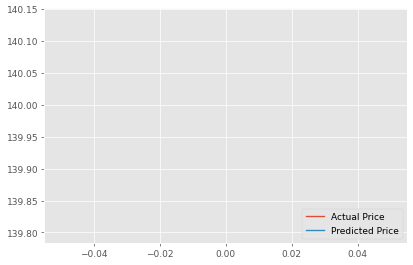


##############################################################################
Tomorrow's  ZOMATO.NS  Closing Price Prediction by Linear Regression:  139.9560357460993
Linear Regression RMSE: 0.3358576405230451
##############################################################################


(          Open        High         Low       Close   Adj Close     Volume  \
 0   116.000000  138.899994  115.000000  126.000000  126.000000  694895290   
 1   126.349998  143.750000  125.300003  140.649994  140.649994  249723854   
 2   141.699997  147.800003  127.750000  132.899994  132.899994  240341900   
 3   131.000000  135.000000  123.550003  131.199997  131.199997  159793731   
 4   134.949997  144.000000  132.199997  141.550003  141.550003  117973089   
 5   142.600006  142.699997  131.000000  133.500000  133.500000   88312522   
 6   135.750000  140.750000  135.149994  139.699997  139.699997   66909732   
 7   137.000000  140.800003  137.000000  139.399994  139.399994   46610001   
 8   139.800003  141.000000  135.250000  138.399994  138.399994   41134419   
 9   138.750000  138.899994  132.000000  134.949997  134.949997   38437134   
 10  135.500000  136.199997  130.100006  131.350006  131.350006   31975356   
 11  132.399994  133.550003  127.250000  130.600006  130.600006 

In [35]:
linear_reg(df)